In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score as AUC

## SVD++ Results

In [2]:
svd_results = pd.read_csv("SVDppResults2.csv")

In [3]:
svd_auc_score = AUC(np.array(svd_results["skipped"]), np.array(svd_results["prediction"]))
print("AUC Score:", svd_auc_score)

AUC Score: 0.807650502126


In [4]:
np.shape(svd_results)

(1151142, 7)

## Neural Network Results

In [5]:
nn_results = pd.read_csv("NNResults2.csv")

In [6]:
nn_auc_score = AUC(np.array(nn_results["skipped"]), np.array(nn_results["prediction"]))
print("AUC Score:", nn_auc_score)

AUC Score: 0.679825944415


In [7]:
np.shape(nn_results)

(1151204, 7)

In [8]:
list(nn_results)

['artist-name',
 'prediction',
 'skipped',
 'timestamp',
 'track-name',
 'userid',
 'weekend']

## Combined Results

In [9]:
combined_results = pd.merge(svd_results, nn_results, how="inner",
                            on = ['artist-name','skipped','timestamp','track-name','userid','weekend'],
                           suffixes = ["_svd", "_nn"])

In [10]:
np.shape(combined_results)

(1074514, 8)

In [11]:
combined_results.head()

,userid,track-name,artist-name,weekend,timestamp,skipped,prediction_svd,prediction_nn
0,user_000001,Monde,Hudson Mohawke,0,2009-02-16 11:11:10,0,0.034001,0.000031
1,user_000001,Overnight,Hudson Mohawke,0,2009-02-16 12:07:09,0,0.026386,0.000086
2,user_000001,Speed Stick,Hudson Mohawke,0,2009-02-16 12:09:58,0,0.023940,0.000070
3,user_000001,Velvet Peel,Hudson Mohawke,0,2009-02-16 12:12:03,0,0.023543,0.000064
4,user_000001,Yonard,Hudson Mohawke,0,2009-02-16 12:14:22,0,0.035618,0.000058


### Normalizing the probabilities of both models by scaled ranking

In [12]:
combined_results["prediction_svd_scaled"] = combined_results["prediction_svd"].rank() / combined_results.shape[0]
combined_results["prediction_nn_scaled"] = combined_results["prediction_nn"].rank() / combined_results.shape[0]

In [13]:
combined_results.head()

,userid,track-name,artist-name,weekend,timestamp,skipped,prediction_svd,prediction_nn,prediction_svd_scaled,prediction_nn_scaled
0,user_000001,Monde,Hudson Mohawke,0,2009-02-16 11:11:10,0,0.034001,0.000031,0.881653,0.881157
1,user_000001,Overnight,Hudson Mohawke,0,2009-02-16 12:07:09,0,0.026386,0.000086,0.846324,0.885753
2,user_000001,Speed Stick,Hudson Mohawke,0,2009-02-16 12:09:58,0,0.023940,0.000070,0.830574,0.884768
3,user_000001,Velvet Peel,Hudson Mohawke,0,2009-02-16 12:12:03,0,0.023543,0.000064,0.828102,0.884328
4,user_000001,Yonard,Hudson Mohawke,0,2009-02-16 12:14:22,0,0.035618,0.000058,0.887119,0.883888


## Weighted Averaging the models

In [14]:
svd_weights = np.linspace(0,1,21)

In [15]:
svd_weights

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ])

In [16]:
nn_weights = 1 - svd_weights

In [17]:
ensemble_auc_scores = np.zeros(len(svd_weights))

In [18]:
i = 0
for svd, nn in zip(svd_weights, nn_weights):
    ensemble_preds = svd * np.array(combined_results["prediction_svd_scaled"]) + \
                      nn * np.array(combined_results["prediction_nn_scaled"])
    ensemble_auc_scores[i] = AUC(np.array(combined_results["skipped"]), ensemble_preds)
    i+=1
    

In [19]:
pd.DataFrame({"SVD++ Weight": svd_weights, "NN Weight": nn_weights, "Ensemble AUC": ensemble_auc_scores})

,Ensemble AUC,NN Weight,SVD++ Weight
0,0.682390,1.00,0.00
1,0.762662,0.95,0.05
2,0.763540,0.90,0.10
3,0.764273,0.85,0.15
4,0.764855,0.80,0.20
5,0.765251,0.75,0.25
6,0.766057,0.70,0.30
7,0.769095,0.65,0.35
8,0.774347,0.60,0.40
9,0.781577,0.55,0.45


In [20]:
import matplotlib.pyplot as plt

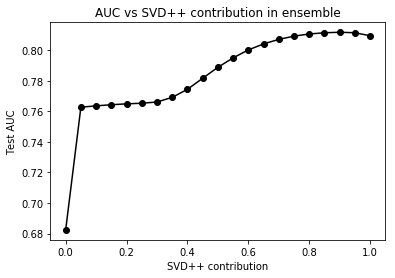

In [24]:
plt.plot(svd_weights, ensemble_auc_scores, '-ko')
plt.xlabel('SVD++ contribution')
plt.ylabel('Test AUC')
plt.title("AUC vs SVD++ contribution in ensemble")
plt.show()


### Optimum ensemble is obtained at SVD++: 90% and NN: 10%